In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
from astropy.table import Table
from scipy.optimize import curve_fit

## redshift dependent mass cut on centrals

In [2]:
def mass(z):
    return -0.1*z**2-0.18*z+11.294

In [3]:
mass(0.3)

11.231

## NFW model

In [4]:
def fit_nfw(xdata, ydata):
    popt,pcov = curve_fit(nfw, xdata[6:], ydata[6:], p0=[180,4e-5], method='trf')
    return popt

In [13]:
def sersic(r,Ie,re):
    n=5.5
    b=2*n-1./3
    re=13.1
    sersic = Ie * np.exp(-b*((r/float(re))**(1/float(n))-1))
    return sersic
    
def nfw(r, rs, I):
    x = r / float(rs)
    y = np.piecewise(x, [x < 1, x==1, x > 1],
                     [lambda x:I*(x**2-1)**(-1)*(1-2/np.sqrt(1-x**2)*np.arctanh(np.sqrt((1-x)/(1+x)))), 
                      lambda x:I*1./3, 
                      lambda x:I*(x**2-1)**(-1)*(1-2/np.sqrt(x**2-1)*np.arctan(np.sqrt((x-1)/(1+x))))])
    return y

def nfw_sersic(r, rs, I, Ie,re):
    
    def sersic(r,Ie,re):
        n=5.5
        b=2*n-1./3
        re=13.1
        sersic = Ie * np.exp(-b*((r/float(re))**(1/float(n))-1))
        return sersic
    
    def nfw(r, rs, I):
        x = r / float(rs)
        y = np.piecewise(x, [x < 1, x==1, x > 1],
                     [lambda x:I*(x**2-1)**(-1)*(1-2/np.sqrt(1-x**2)*np.arctanh(np.sqrt((1-x)/(1+x)))), 
                      lambda x:I*1./3, 
                      lambda x:I*(x**2-1)**(-1)*(1-2/np.sqrt(x**2-1)*np.arctan(np.sqrt((x-1)/(1+x))))])
        return y
    
    n=5.5
    b=2*n-1./3
    sersic = sersic(r,Ie,re)
    nfw = nfw(r,rs,I)
    
    return nfw + sersic

def fit_nfw_sersic(xdata, ydata, ydata_err):
    popt,pcov = curve_fit(nfw_sersic, xdata[4:], ydata[4:], sigma=ydata_err[4:], p0=[300,4e-5,1e-5,13.1])
    return popt


## Mass Surface Density Plot

In [10]:
def combine_deep(mass_bin, csfq, ssfq, z, mode='count',path = 'CUT_deep_catalogs/calibration_deep/'):
    
    def massive_counts(cat_name,z,csfq):
        cat = Table.read('CUT_deep_catalogs/massive_counts/'+cat_name+'_0.09_11.15.fits')
        cat = cat[cat['zphot']==z]
        if len(cat)==0:
            return 0
        
        if csfq=='csf':
            return cat['count_csf'][0]
        elif csfq=='cq':
            return cat['count_cq'][0]
        else:
            return cat['count'][0]
            
    radial_COSMOS = np.load(path+mode+'COSMOS_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'.npy')
    radial_DEEP = np.load(path+mode+'DEEP_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'.npy')
    radial_SXDS = np.load(path+mode+'SXDS_uddd_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'.npy')
    radial_ELAIS = np.load(path+mode+'ELAIS_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'.npy')
    radial_XMM = np.load(path+mode+'XMM-LSS_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'.npy')
    
    radial_COSMOS_err = np.load(path+mode+'COSMOS_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'_err.npy')
    radial_DEEP_err = np.load(path+mode+'DEEP_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'_err.npy')
    radial_SXDS_err = np.load(path+mode+'SXDS_uddd_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'_err.npy')
    radial_ELAIS_err = np.load(path+mode+'ELAIS_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'_err.npy')
    radial_XMM_err = np.load(path+mode+'XMM-LSS_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'_err.npy')
    
    count_COSMOS = massive_counts('COSMOS_deep',z,csfq)
    count_DEEP = massive_counts('DEEP_deep',z,csfq)
    count_SXDS = massive_counts('SXDS_uddd',z,csfq)
    count_ELAIS = massive_counts('ELAIS_deep',z,csfq)
    count_XMM = massive_counts('XMM-LSS_deep',z,csfq)
    count_total = sum([count_COSMOS,count_DEEP,count_SXDS,count_ELAIS,count_XMM])
    print(count_total)

    radial_total = (radial_COSMOS*count_COSMOS+radial_XMM*count_XMM+radial_ELAIS*count_ELAIS+radial_SXDS*count_SXDS+radial_DEEP*count_DEEP)/count_total
    radial_total_err = np.sqrt(radial_COSMOS_err**2*count_COSMOS**2+radial_XMM_err**2*count_XMM**2+radial_ELAIS_err**2*count_ELAIS**2+radial_SXDS_err**2*count_SXDS**2+radial_DEEP_err**2*count_DEEP**2)/count_total
                               
    return radial_total, radial_total_err

In [11]:
def combine_deep_inside(mass_bin, csfq, ssfq, z, mode='count',path = 'CUT_deep_catalogs/calibration_deep/'):
    
    def massive_counts(cat_name,z,csfq):
        cat = Table.read('CUT_deep_catalogs/massive_counts_inside/'+cat_name+'_0.09_11.15.fits')
        cat = cat[cat['zphot']==z]
        if len(cat)==0:
            return 0
        
        if csfq=='csf':
            return cat['count_csf'][0]
        elif csfq=='cq':
            return cat['count_cq'][0]
        else:
            return cat['count'][0]
            
    radial_COSMOS = np.load(path+mode+'COSMOS_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'.npy')
    radial_DEEP = np.load(path+mode+'DEEP_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'.npy')
    radial_SXDS = np.load(path+mode+'SXDS_uddd_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'.npy')
    radial_ELAIS = np.load(path+mode+'ELAIS_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'.npy')
    radial_XMM = np.load(path+mode+'XMM-LSS_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'.npy')
    
    radial_COSMOS_err = np.load(path+mode+'COSMOS_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'_err.npy')
    radial_DEEP_err = np.load(path+mode+'DEEP_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'_err.npy')
    radial_SXDS_err = np.load(path+mode+'SXDS_uddd_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'_err.npy')
    radial_ELAIS_err = np.load(path+mode+'ELAIS_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'_err.npy')
    radial_XMM_err = np.load(path+mode+'XMM-LSS_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'_err.npy')
    
    count_COSMOS = massive_counts('COSMOS_deep',z,csfq)
    count_DEEP = massive_counts('DEEP_deep',z,csfq)
    count_SXDS = massive_counts('SXDS_uddd',z,csfq)
    count_ELAIS = massive_counts('ELAIS_deep',z,csfq)
    count_XMM = massive_counts('XMM-LSS_deep',z,csfq)
    count_total = sum([count_COSMOS,count_DEEP,count_SXDS,count_ELAIS,count_XMM])
    print(count_total)

    radial_total = (radial_COSMOS*count_COSMOS+radial_XMM*count_XMM+radial_ELAIS*count_ELAIS+radial_SXDS*count_SXDS+radial_DEEP*count_DEEP)/count_total
    radial_total_err = np.sqrt(radial_COSMOS_err**2*count_COSMOS**2+radial_XMM_err**2*count_XMM**2+radial_ELAIS_err**2*count_ELAIS**2+radial_SXDS_err**2*count_SXDS**2+radial_DEEP_err**2*count_DEEP**2)/count_total
                               
    return radial_total, radial_total_err

1601.0
2090.0
3885.0
[2.92661789e+02 4.36763500e-05 6.05426034e-04 1.31000000e+01]
[3.26986704e+02 3.08597242e-05 8.04566750e-04 1.31000000e+01]
[4.00830885e+02 2.87891525e-05 6.17006821e-04 1.31000000e+01]


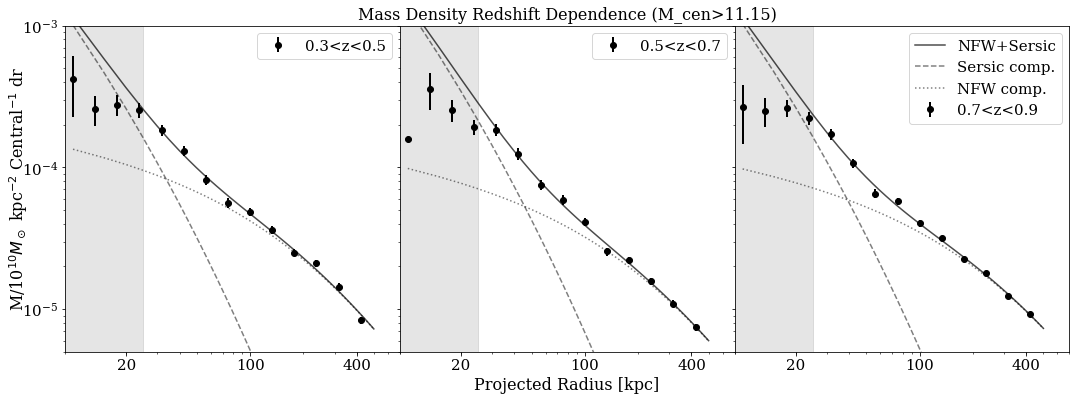

In [25]:
# Mass Surface Density Plot

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(18,6))

mass_radial_4 = combine_deep('9.0','all','all',0.4,mode='mass')
mass_radial_6 = combine_deep('9.0','all','all',0.6,mode='mass')
mass_radial_8 = combine_deep('9.0','all','all',0.8,mode='mass')
bin_edges = np.load('bin_edges.npy')[:-1]

axs[0].errorbar(bin_edges, mass_radial_4[0],mass_radial_4[1],fmt='ok',label='0.3<z<0.5',linewidth=2)
axs[1].errorbar(bin_edges, mass_radial_6[0],mass_radial_6[1],fmt='ok',label='0.5<z<0.7',linewidth=2)
axs[2].errorbar(bin_edges, mass_radial_8[0],mass_radial_8[1],fmt='ok',label='0.7<z<0.9',linewidth=2)

axs[0].set_yscale('log')
axs[0].set_xscale('log')

nfw_x = np.linspace(10,500,num=100)
popt4 = fit_nfw_sersic(bin_edges,mass_radial_4[0],mass_radial_4[1])
popt6 = fit_nfw_sersic(bin_edges,mass_radial_6[0],mass_radial_6[1])
popt8 = fit_nfw_sersic(bin_edges,mass_radial_8[0],mass_radial_8[1])
print(popt4)
print(popt6)
print(popt8)

axs[0].plot(nfw_x,nfw_sersic(nfw_x, popt4[0],popt4[1],popt4[2],popt4[3]),'k',alpha=0.7)
axs[1].plot(nfw_x,nfw_sersic(nfw_x, popt6[0],popt6[1],popt6[2],popt6[3]),'k',alpha=0.7)
axs[2].plot(nfw_x,nfw_sersic(nfw_x, popt8[0],popt8[1],popt8[2],popt8[3]),'k',alpha=0.7,label='NFW+Sersic')

axs[0].plot(nfw_x,sersic(nfw_x, popt4[2],popt4[3]),'--k',alpha=0.5)
axs[1].plot(nfw_x,sersic(nfw_x, popt6[2],popt6[3]),'--k',alpha=0.5)
axs[2].plot(nfw_x,sersic(nfw_x, popt8[2],popt8[3]),'--k',alpha=0.5,label='Sersic comp.')

axs[0].plot(nfw_x,nfw(nfw_x,popt4[0],popt4[1]),':k',alpha=0.5)
axs[1].plot(nfw_x,nfw(nfw_x,popt6[0],popt6[1]),':k',alpha=0.5)
axs[2].plot(nfw_x,nfw(nfw_x,popt8[0],popt8[1]),':k',alpha=0.5,label='NFW comp.')

axs[0].axvspan(9, 25, alpha=0.1, color='k')
axs[1].axvspan(9, 25, alpha=0.1, color='k')
axs[2].axvspan(9, 25, alpha=0.1, color='k')

axs[0].legend(fontsize=15)
axs[1].legend(fontsize=15)
axs[2].legend(fontsize=15)
axs[0].set_xticks([20, 100, 400])
axs[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[0].set_xlim([9,700])
axs[0].set_ylim([5e-6,1e-3])

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)

plt.xlabel('Projected Radius [kpc]', fontsize=16)
plt.ylabel(r'M/10$^{10}M_\odot$ kpc$^{-2}$ Central$^{-1}$ dr', fontsize=16)
plt.title('Mass Density Redshift Dependence (M_cen>11.15)', fontsize=16)
plt.savefig('figures/mass_density_zdependence.png')
plt.show() 

1601.0
2090.0
3885.0
[3.38895112e+02 1.93273103e-05 3.85300435e-04 1.31000000e+01]
[2.87526884e+02 1.72963508e-05 2.90201591e-04 1.31000000e+01]
[4.87804175e+02 1.12320117e-05 1.93630323e-04 1.31000000e+01]


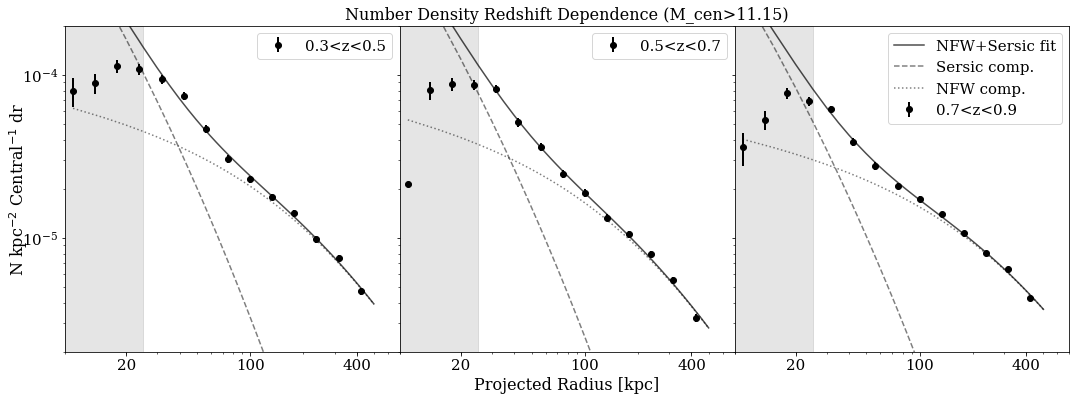

In [26]:
# Number Surface Density Plot


plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(18,6))

count_radial_4 = combine_deep('9.0','all','all',0.4,mode='count')
count_radial_6 = combine_deep('9.0','all','all',0.6,mode='count')
count_radial_8 = combine_deep('9.0','all','all',0.8,mode='count')
bin_edges = np.load('bin_edges.npy')[:-1]

axs[0].errorbar(bin_edges, count_radial_4[0],count_radial_4[1],fmt='ok',label='0.3<z<0.5',linewidth=2)
axs[1].errorbar(bin_edges, count_radial_6[0],count_radial_6[1],fmt='ok',label='0.5<z<0.7',linewidth=2)
axs[2].errorbar(bin_edges, count_radial_8[0],count_radial_8[1],fmt='ok',label='0.7<z<0.9',linewidth=2)

axs[0].set_yscale('log')
axs[0].set_xscale('log')

nfw_x = np.linspace(10,500,num=100)
popt4 = fit_nfw_sersic(bin_edges,count_radial_4[0],count_radial_4[1])
popt6 = fit_nfw_sersic(bin_edges,count_radial_6[0],count_radial_6[1])
popt8 = fit_nfw_sersic(bin_edges,count_radial_8[0],count_radial_8[1])
print(popt4)
print(popt6)
print(popt8)

axs[0].plot(nfw_x,nfw_sersic(nfw_x, popt4[0],popt4[1],popt4[2],popt4[3]),'k',alpha=0.7)
axs[1].plot(nfw_x,nfw_sersic(nfw_x, popt6[0],popt6[1],popt6[2],popt6[3]),'k',alpha=0.7)
axs[2].plot(nfw_x,nfw_sersic(nfw_x, popt8[0],popt8[1],popt8[2],popt8[3]),'k',alpha=0.7,label='NFW+Sersic fit')

axs[0].plot(nfw_x,sersic(nfw_x, popt4[2],popt4[3]),'--k',alpha=0.5)
axs[1].plot(nfw_x,sersic(nfw_x, popt6[2],popt6[3]),'--k',alpha=0.5)
axs[2].plot(nfw_x,sersic(nfw_x, popt8[2],popt8[3]),'--k',alpha=0.5,label='Sersic comp.')

axs[0].plot(nfw_x,nfw(nfw_x,popt4[0],popt4[1]),':k',alpha=0.5)
axs[1].plot(nfw_x,nfw(nfw_x,popt6[0],popt6[1]),':k',alpha=0.5)
axs[2].plot(nfw_x,nfw(nfw_x,popt8[0],popt8[1]),':k',alpha=0.5,label='NFW comp.')

axs[0].axvspan(9, 25, alpha=0.1, color='k')
axs[1].axvspan(9, 25, alpha=0.1, color='k')
axs[2].axvspan(9, 25, alpha=0.1, color='k')

axs[0].legend(fontsize=15)
axs[1].legend(fontsize=15)
axs[2].legend(fontsize=15)
axs[0].set_xticks([20, 100, 400])
axs[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[0].set_xlim([9,700])
axs[0].set_ylim([2e-6,2e-4])

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)

plt.xlabel('Projected Radius [kpc]', fontsize=16)
plt.ylabel(r'N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=16)
plt.title('Number Density Redshift Dependence (M_cen>11.15)', fontsize=16)
plt.savefig('figures/number_density_zdependence.png')
plt.show() 

## New bkg vs Old bkg
old:direct measure in bins, new: measure in whole aperture and divide into bins

In [ ]:
radial_new_bkg = combine_deep('9.5', 'all', 'all', 0.6, mode='count',path='CUT_deep_catalogs/new_bkg/')
radial_old_bkg = combine_deep('9.5', 'all', 'all', 0.6, mode='count',path='CUT_deep_catalogs/old_bkg/')
bin_edges = np.load('CUT_deep_catalogs/new_bkg/bin_edges.npy')

fig = plt.figure(figsize=(9, 8))
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)
plt.errorbar(bin_edges[:-1],radial_new_bkg[0],radial_new_bkg[1],fmt='k',label='new')
plt.errorbar(bin_edges[:-1],radial_old_bkg[0],radial_old_bkg[1],fmt='--k',label='old')

plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=14)
plt.xlabel('Projected Radius [kpc]', fontsize=14)
plt.ylabel(r'N kpc$^{-2}$ UMG$^{-1}$ dr', fontsize=14)
plt.title('Companion Mass Cut at M=9.5', fontsize=14)
plt.savefig('figures/radial_count_old_new_bkg.png')
plt.legend(fontsize=14)
plt.show()

In [ ]:
path = 'CUT_deep_catalogs/new_bkg/'
sigma_tot = np.load(path+'countCOSMOS_deep_9.5_all_all_0.6_err.npy')
sigma_sample = np.load(path+'countCOSMOS_deep_9.5_all_all_0.6_sample_err.npy')
sigma_bkg_new = np.load(path+'countCOSMOS_deep_9.5_all_all_0.6_bkg_err.npy')
path = 'CUT_deep_catalogs/old_bkg/'
sigma_bkg_old = np.load(path+'countCOSMOS_deep_9.5_all_all_0.6_bkg_err.npy')
bin_edges = np.load('CUT_deep_catalogs/new_bkg/bin_edges.npy')[:-1]

fig = plt.figure(figsize=(8, 6))
plt.plot(bin_edges,sigma_tot,label='old_total')
plt.plot(bin_edges,sigma_sample,label='old_sample')
plt.plot(bin_edges,sigma_bkg_old,'g',label='old_bkg')
plt.plot(bin_edges,sigma_bkg_new,'--g',label='new_bkg')
plt.yscale('log')
plt.xlabel('Radius [kpc]',fontsize=14)
plt.ylabel('Count Error',fontsize=14)
plt.legend(fontsize=14) 
plt.tight_layout()
plt.savefig('figures/sigma_relative_contribution.png')
plt.show()

## With vs Without correction for masking

In [ ]:
radial_c = combine_deep('9.5', 'all', 'all', 0.6, mode='count',path='CUT_deep_catalogs/with_mask_correction/')
radial_noc = combine_deep('9.5', 'all', 'all', 0.6, mode='count',path='CUT_deep_catalogs/without_mask_correction/')
bin_edges = np.load('CUT_deep_catalogs/new_bkg/bin_edges.npy')

fig = plt.figure(figsize=(9, 8))
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)
plt.errorbar(bin_edges[:-1],radial_c[0],radial_c[1],fmt='k',label='with correction')
plt.errorbar(bin_edges[:-1],radial_noc[0],radial_noc[1],fmt='--k',label='without correction')

plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=14)
plt.xlabel('Projected Radius [kpc]', fontsize=14)
plt.ylabel(r'N kpc$^{-2}$ UMG$^{-1}$ dr', fontsize=14)
plt.title('Satellite Mass Cut at M=9.5 (all deep catalogs)', fontsize=14)
plt.savefig('figures/radial_count_mask_correction.png')
plt.legend(fontsize=14)
plt.show()

## With and Without correction for completeness

In [ ]:
radial_c = combine_deep('9.5', 'all', 'all', 0.6, mode='count',path='CUT_deep_catalogs/completeness_correction/correction_')
radial_noc = combine_deep('9.5', 'all', 'all', 0.6, mode='count',path='CUT_deep_catalogs/completeness_correction/')
bin_edges = np.load('CUT_deep_catalogs/new_bkg/bin_edges.npy')

fig = plt.figure(figsize=(9, 8))
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)
plt.errorbar(bin_edges[:-1],radial_c[0],radial_c[1],fmt='k',label='with correction')
plt.errorbar(bin_edges[:-1],radial_noc[0],radial_noc[1],fmt='--k',label='without correction')

plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=14)
plt.xlabel('Projected Radius [kpc]', fontsize=14)
plt.ylabel(r'N kpc$^{-2}$ UMG$^{-1}$ dr', fontsize=14)
plt.title('Satellite Mass Cut at M=9.5 (all deep catalogs)', fontsize=14)
plt.savefig('figures/radial_count_completeness_correction.png')
plt.legend(fontsize=14)
plt.show()

## Account for photoz, mass and SSFR uncertainty
scattered photoz esitmations sigma_z = 0.044*(1+z)

In [ ]:
def combine_deep_scatter(mass_bin, csfq, ssfq, z, mode='count',run_id='0',path = 'CUT_deep_catalogs/calibration_deep/'):
    
    def massive_counts(cat_name,z,csfq):
        cat = Table.read('CUT_deep_catalogs/massive_counts_inside/run'+str(run_id)+'_'+cat_name+'_0.09_11.15.fits')
        cat = cat[cat['zphot']==z]
        if len(cat)==0:
            return 0
        
        if csfq=='csf':
            return cat['count_csf'][0]
        elif csfq=='cq':
            return cat['count_cq'][0]
        else:
            return cat['count'][0]
            
    radial_COSMOS = np.load(path+mode+'COSMOS_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'.npy')
    radial_DEEP = np.load(path+mode+'DEEP_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'.npy')
    radial_SXDS = np.load(path+mode+'SXDS_uddd_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'.npy')
    radial_ELAIS = np.load(path+mode+'ELAIS_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'.npy')
    radial_XMM = np.load(path+mode+'XMM-LSS_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'.npy')
    
    radial_COSMOS_err = np.load(path+mode+'COSMOS_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'_err.npy')
    radial_DEEP_err = np.load(path+mode+'DEEP_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'_err.npy')
    radial_SXDS_err = np.load(path+mode+'SXDS_uddd_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'_err.npy')
    radial_ELAIS_err = np.load(path+mode+'ELAIS_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'_err.npy')
    radial_XMM_err = np.load(path+mode+'XMM-LSS_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'_err.npy')
    
    count_COSMOS = massive_counts('COSMOS_deep',z,csfq)
    count_DEEP = massive_counts('DEEP_deep',z,csfq)
    count_SXDS = massive_counts('SXDS_uddd',z,csfq)
    count_ELAIS = massive_counts('ELAIS_deep',z,csfq)
    count_XMM = massive_counts('XMM-LSS_deep',z,csfq)
    count_total = sum([count_COSMOS,count_DEEP,count_SXDS,count_ELAIS,count_XMM])
    print(count_total)

    radial_total = (radial_COSMOS*count_COSMOS+radial_XMM*count_XMM+radial_ELAIS*count_ELAIS+radial_SXDS*count_SXDS+radial_DEEP*count_DEEP)/count_total
    radial_total_err = np.sqrt(radial_COSMOS_err**2*count_COSMOS**2+radial_XMM_err**2*count_XMM**2+radial_ELAIS_err**2*count_ELAIS**2+radial_SXDS_err**2*count_SXDS**2+radial_DEEP_err**2*count_DEEP**2)/count_total
                               
    return radial_total, radial_total_err

In [ ]:
radial_run0 = combine_deep_scatter('9.5', 'all', 'all', 0.6, mode='count',run_id=0,path='CUT_deep_catalogs/scattered/run0_')
radial_run1 = combine_deep_scatter('9.5', 'all', 'all', 0.6, mode='count',run_id=2,path='CUT_deep_catalogs/scattered/run1_')
radial_run2 = combine_deep_scatter('9.5', 'all', 'all', 0.6, mode='count',run_id=2,path='CUT_deep_catalogs/scattered/run2_')
radial_run3 = combine_deep_scatter('9.5', 'all', 'all', 0.6, mode='count',run_id=3,path='CUT_deep_catalogs/scattered/run3_')
radial_run4 = combine_deep_scatter('9.5', 'all', 'all', 0.6, mode='count',run_id=4,path='CUT_deep_catalogs/scattered/run4_')
radial_run5 = combine_deep_scatter('9.5', 'all', 'all', 0.6, mode='count',run_id=5,path='CUT_deep_catalogs/scattered/run5_')
radial_run6 = combine_deep_scatter('9.5', 'all', 'all', 0.6, mode='count',run_id=6,path='CUT_deep_catalogs/scattered/run6_')
radial_run7 = combine_deep_scatter('9.5', 'all', 'all', 0.6, mode='count',run_id=7,path='CUT_deep_catalogs/scattered/run7_')
radial_run8 = combine_deep_scatter('9.5', 'all', 'all', 0.6, mode='count',run_id=8,path='CUT_deep_catalogs/scattered/run8_')

bin_edges = np.load('CUT_deep_catalogs/new_bkg/bin_edges.npy')

fig = plt.figure(figsize=(9, 8))
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)
plt.errorbar(bin_edges[:-1],radial_run0[0],radial_run0[1],fmt='k',label='')
plt.errorbar(bin_edges[:-1],radial_run1[0],radial_run1[1],fmt='k',label='')
plt.errorbar(bin_edges[:-1],radial_run2[0],radial_run2[1],fmt='k',label='')
plt.errorbar(bin_edges[:-1],radial_run3[0],radial_run3[1],fmt='k',label='')
plt.errorbar(bin_edges[:-1],radial_run4[0],radial_run4[1],fmt='k',label='')
plt.errorbar(bin_edges[:-1],radial_run5[0],radial_run5[1],fmt='k',label='')
plt.errorbar(bin_edges[:-1],radial_run6[0],radial_run6[1],fmt='k',label='')
plt.errorbar(bin_edges[:-1],radial_run7[0],radial_run7[1],fmt='k',label='')
plt.errorbar(bin_edges[:-1],radial_run8[0],radial_run8[1],fmt='k',label='')

plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=14)
plt.xlabel('Projected Radius [kpc]', fontsize=14)
plt.ylabel(r'N kpc$^{-2}$ UMG$^{-1}$ dr', fontsize=14)
plt.title('Companion Mass Cut at M=9.5 (all deep catalogs)', fontsize=14)
plt.savefig('figures/scattered_zphot.png')
plt.legend(fontsize=14)
plt.show()

In [ ]:
# find scatter caused by systematic error
print(radial_run0[0]-radial_run1[0])
np.std([radial_run0[0],radial_run1[0]])

## Link through Redshift

1126.0
1450.0
2757.0


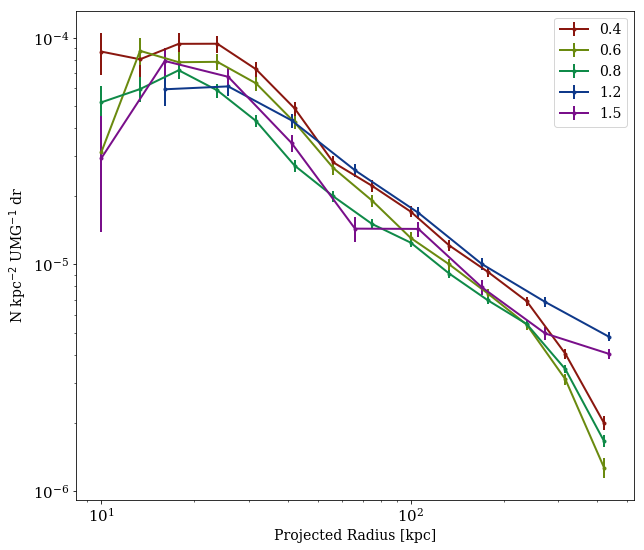

In [28]:
# sns.set_style("ticks")
import seaborn as sns
sns.set_palette(sns.hls_palette(5, l=.3, s=.8))

radial_4 = combine_deep_inside('9.5', 'all', 'all', 0.4, mode='count')
radial_6 = combine_deep_inside('9.5', 'all', 'all', 0.6, mode='count')
radial_8 = combine_deep_inside('9.5', 'all', 'all', 0.8, mode='count')

radial_12_sf = np.load('calibration_uddd/count_9.5_ssf_1.2.npy')
radial_15_sf = np.load('calibration_uddd/count_9.5_ssf_1.5.npy')
radial_12_q = np.load('calibration_uddd/count_9.5_sq_1.2.npy')
radial_15_q = np.load('calibration_uddd/count_9.5_sq_1.5.npy')
radial_12 = radial_12_sf*2.5+radial_12_q
radial_15 = radial_15_sf*2.5+radial_15_q
radial_12_err = np.load('calibration_uddd/count_9.5_all_1.2_err.npy')
radial_15_err = np.load('calibration_uddd/count_9.5_all_1.5_err.npy')

bin_edges = np.load('bin_edges.npy')
bin_edges_uddd = np.load('calibration_uddd/new_bin_edges.npy')

fig = plt.figure(figsize=(10, 9))
plt.errorbar(bin_edges[:-1], radial_4[0], fmt='.-', yerr=radial_4[1], label='0.4',linewidth=2)
plt.errorbar(bin_edges[:-1], radial_6[0], fmt='.-', yerr=radial_6[1], label='0.6',linewidth=2)
plt.errorbar(bin_edges[:-1], radial_8[0], fmt='.-', yerr=radial_8[1], label='0.8',linewidth=2)
plt.errorbar(bin_edges_uddd [:-1], radial_12, fmt='.-', yerr=radial_12_err, label='1.2',linewidth=2)
plt.errorbar(bin_edges_uddd [:-1], radial_15, fmt='.-', yerr=radial_15_err, label='1.5',linewidth=2)

plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=14)
plt.xlabel('Projected Radius [kpc]', fontsize=14)
plt.ylabel(r'N kpc$^{-2}$ UMG$^{-1}$ dr', fontsize=14)
plt.savefig('figures/radial_count_0.3_1.5.png')
plt.show()